In [ ]:
'''
 * Copyright (c) 2004 Radhamadhab Dalai
 *
 * Permission is hereby granted, free of charge, to any person obtaining a copy
 * of this software and associated documentation files (the "Software"), to deal
 * in the Software without restriction, including without limitation the rights
 * to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
 * copies of the Software, and to permit persons to whom the Software is
 * furnished to do so, subject to the following conditions:
 *
 * The above copyright notice and this permission notice shall be included in
 * all copies or substantial portions of the Software.
 *
 * THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
 * IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
 * FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
 * AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
 * LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
 * OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN
 * THE SOFTWARE.
'''

## Semantic Image Labeling and Surface Layout

### TextonBoost Overview

TextonBoost (Shotton et al., 2009) is a technique for semantic image labeling that combines texture-based features with context information.

### Key Components:

1. **Texton Conversion**: 
   - Convert original image to textons (discrete texture values)
   - Each pixel is assigned a value indicating texture type
   - Mathematically, we can represent this as:
   
   $$T(x,y) = \text{textonFunction}(I(x,y))$$
   
   where $I(x,y)$ is the image intensity at position $(x,y)$

2. **Weak Classifiers**:
   - Uses offset rectangle features
   - Counts textons of specific types within offset rectangles
   - For a rectangle $R$ offset from position $(x,y)$ by vector $\vec{d}$:
   
   $$f_R(x,y) = \sum_{(p,q) \in R+(x,y)+\vec{d}} [T(p,q) = t]$$
   
   where $t$ is a specific texton type and $[·]$ is the Iverson bracket (1 if condition is true, 0 otherwise)

3. **Contextual Information**:
   - Provides information about both:
     - The object itself (contains object-specific textons)
     - Nearby objects (proximity to other texture types)
   - Contextual probability can be modeled as:
   
   $$P(c|x,y) = \text{softmax}\left(\sum_i w_i f_i(x,y)\right)$$
   
   where $c$ is the class, $f_i$ are weak classifiers, and $w_i$ are learned weights

4. **Edge Refinement**:
   - Initial per-pixel classification lacks precision at object boundaries
   - Conditional Random Field (CRF) improves edge accuracy
   - The CRF energy function:
   
   $$E(c) = \sum_i \psi_i(c_i) + \sum_{i,j \in \mathcal{N}} \psi_{ij}(c_i, c_j)$$
   
   where $\psi_i$ is the unary potential from classifier output and $\psi_{ij}$ is the pairwise potential encouraging similar nearby pixels to have the same label

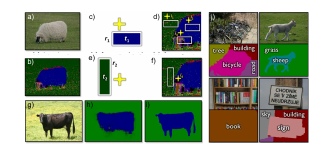

Fig.22 Semantic image labeling using “TextonBoost”. a) Original image. b) Image converted to textons – a discrete value at each pixel indicating the type of texture that is present. c) The system was based on weak clas- siﬁers that count the number of textons of a certain type within a rectangle that is oﬀset from the current position (yellow cross). d) This provides both information about the object itself (contains sheep-like textons) and nearby objects (near to grass-like textons). e,f) Another example of a weak clas- siﬁer. g) Test image. h) Per-pixel classiﬁcation is not very precise at the edges of objects and so i) a conditional random ﬁeld is used to improve the result. j) Examples of results and ground truth. Adapted from Shotton c et al. (2009) �2009 Springer.

## Surface Layout Recovery

Surface layout recovery assigns each pixel to one of three classes:
1. Support object (e.g., floor)
2. Vertical object (e.g., building)
3. Sky

### Mathematical Formulation:

For each pixel, we assign a label $w \in \{1, 2, 3\}$ based on local image data $x$.

Hoiem et al. (2007) used:

1. **Superpixel Representation**:
   - Over-segmentation into homogeneous regions
   - Each superpixel $s$ has feature vector $x_s$
   
2. **One-against-all Classification**:
   - For each class $k$, compute:
   
   $$P(w=k|x) = \frac{\exp(f_k(x))}{\sum_{j=1}^3 \exp(f_j(x))}$$
   
   where $f_k(x)$ is the classification score for class $k$

3. **LogitBoost with Decision Trees**:
   - Uses multiple weak classifiers (decision trees)
   - Each tree $h_t$ contributes to the final decision:
   
   $$f_k(x) = \sum_{t=1}^T \alpha_t h_t(x)$$
   
   where $\alpha_t$ is the weight for tree $t$

4. **Feature Vector Components**:
   - Location information: $x_{loc}$
   - Appearance features: $x_{app}$
   - Texture descriptors: $x_{tex}$
   - Perspective cues: $x_{persp}$
   
   $$x = [x_{loc}, x_{app}, x_{tex}, x_{persp}]$$

## Performance Analysis

TextonBoost has demonstrated strong performance on the MRSC database, which includes 21 diverse object classes including challenging objects like:
- Wiry objects (bicycles)
- Objects with high variation (dogs)

The approach successfully combines local features with contextual information to improve semantic segmentation accuracy.

Creating synthetic test image...


[ WARN:0@3.907] global loadsave.cpp:248 findDecoder imread_('test_image.jpg'): can't open/read file: check file path/integrity



=== Surface Layout Recovery Demo ===
Extracting features from training images...
Training one-against-all classifiers...
Training classifier for support...
Training classifier for vertical...
Training classifier for sky...


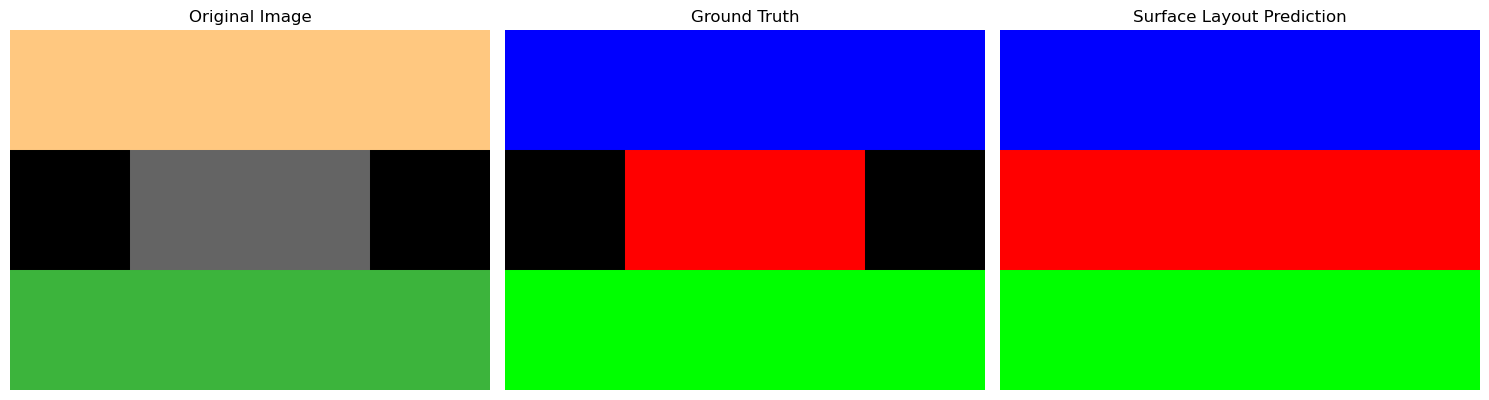


=== TextonBoost Demo ===
Note: TextonBoost training requires more data and time.
Running simplified demo with fewer features and weak classifiers.
Generating filter responses and computing texton maps...
Training classifiers for 4 classes...
Training classifier for class 0...
Training classifier for class 1...
Training classifier for class 2...
Training classifier for class 3...
Extracting features...
Applying classifiers...
Applying CRF...


UnboundLocalError: local variable 'nx' referenced before assignment

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
import cv2
from skimage.segmentation import slic
from skimage.feature import local_binary_pattern
from scipy.stats import entropy
import networkx as nx
from sklearn.cluster import KMeans
from skimage.filters import gabor_kernel
from scipy import ndimage as ndi
from skimage.color import rgb2gray
from itertools import product

class TextonBoost:
    def __init__(self, n_textons=64, n_weak_classifiers=100, random_state=42):
        """
        Initialize TextonBoost model
        
        Parameters:
        -----------
        n_textons : int
            Number of textons to use for clustering
        n_weak_classifiers : int
            Number of weak classifiers for boosting
        random_state : int
            Random seed for reproducibility
        """
        self.n_textons = n_textons
        self.n_weak_classifiers = n_weak_classifiers
        self.random_state = random_state
        self.texton_kmeans = KMeans(n_clusters=n_textons, random_state=random_state)
        self.classifiers = {}
        self.rectangle_features = []
        self.gabor_kernels = self.build_gabor_kernels()
        
    def build_gabor_kernels(self):
        """Create a bank of Gabor filters for texture feature extraction"""
        kernels = []
        for theta in np.linspace(0, np.pi, 4):
            for sigma in (1, 3):
                for frequency in (0.05, 0.25):
                    kernel = np.real(gabor_kernel(frequency, theta=theta,
                                                 sigma_x=sigma, sigma_y=sigma))
                    kernels.append(kernel)
        return kernels
    
    def compute_filter_responses(self, image):
        """Apply Gabor filters to image"""
        # Convert to grayscale if needed
        if image.ndim == 3:
            gray = rgb2gray(image)
        else:
            gray = image
            
        features = []
        for kernel in self.gabor_kernels:
            filtered = ndi.convolve(gray, kernel, mode='wrap')
            features.append(filtered)
        
        # Add LBP features
        lbp = local_binary_pattern(gray, P=8, R=1)
        features.append(lbp)
        
        return np.stack(features, axis=-1)
    
    def generate_rectangle_features(self, n_features=1000, max_size=100):
        """Generate random rectangle features for weak classifiers"""
        np.random.seed(self.random_state)
        features = []
        
        for _ in range(n_features):
            # Generate random rectangle
            width = np.random.randint(10, max_size)
            height = np.random.randint(10, max_size)
            
            # Generate random offset
            offset_x = np.random.randint(-width, width)
            offset_y = np.random.randint(-height, height)
            
            # Generate random texton type to look for
            texton_type = np.random.randint(0, self.n_textons)
            
            features.append({
                'width': width,
                'height': height,
                'offset_x': offset_x,
                'offset_y': offset_y,
                'texton_type': texton_type
            })
            
        self.rectangle_features = features
        return features
    
    def compute_texton_map(self, image):
        """Convert image to texton map"""
        # Extract filter responses
        filter_responses = self.compute_filter_responses(image)
        
        # Reshape for clustering
        h, w, d = filter_responses.shape
        reshaped = filter_responses.reshape(h * w, d)
        
        # Fit or predict based on whether the model is already trained
        if not hasattr(self.texton_kmeans, 'cluster_centers_'):
            self.texton_kmeans.fit(reshaped)
        
        # Get texton labels
        texton_labels = self.texton_kmeans.predict(reshaped)
        texton_map = texton_labels.reshape(h, w)
        
        return texton_map
    
    def compute_rectangle_feature(self, texton_map, feature, x, y):
        """
        Count the number of specified textons in a rectangle offset from (x,y)
        """
        h, w = texton_map.shape
        
        # Calculate rectangle coordinates with offset
        x1 = max(0, x + feature['offset_x'])
        y1 = max(0, y + feature['offset_y'])
        x2 = min(w-1, x1 + feature['width'])
        y2 = min(h-1, y1 + feature['height'])
        
        # Extract rectangle
        rect = texton_map[y1:y2+1, x1:x2+1]
        
        # Count target textons
        count = np.sum(rect == feature['texton_type'])
        
        return count
    
    def extract_features(self, texton_map, positions):
        """Extract rectangle features for all positions"""
        features = np.zeros((len(positions), len(self.rectangle_features)))
        
        for i, (x, y) in enumerate(positions):
            for j, feature in enumerate(self.rectangle_features):
                features[i, j] = self.compute_rectangle_feature(texton_map, feature, x, y)
                
        return features
    
    def fit(self, images, labels):
        """
        Train the TextonBoost model
        
        Parameters:
        -----------
        images : list of numpy arrays
            List of training images
        labels : list of numpy arrays
            List of corresponding label maps
        """
        print("Generating filter responses and computing texton maps...")
        # First, generate filter responses for all images and compute texton maps
        texton_maps = []
        for image in images:
            texton_maps.append(self.compute_texton_map(image))
        
        # Generate random rectangle features if not already done
        if not self.rectangle_features:
            print("Generating rectangle features...")
            self.generate_rectangle_features()
        
        # For each class, train a one-vs-all classifier
        all_classes = np.unique(np.concatenate([lab.flatten() for lab in labels]))
        
        print(f"Training classifiers for {len(all_classes)} classes...")
        for cls in all_classes:
            print(f"Training classifier for class {cls}...")
            
            # Collect training data for this class
            X_train = []
            y_train = []
            
            for texton_map, label_map in zip(texton_maps, labels):
                # Sample positions
                h, w = texton_map.shape
                positions = [(x, y) for y in range(0, h, 10) for x in range(0, w, 10)]
                
                # Extract features for these positions
                features = self.extract_features(texton_map, positions)
                
                # Get binary labels for this class
                binary_labels = np.array([1 if label_map[y, x] == cls else 0 
                                         for x, y in positions])
                
                X_train.append(features)
                y_train.append(binary_labels)
            
            # Concatenate all training data
            X_train = np.vstack(X_train)
            y_train = np.concatenate(y_train)
            
            # Train AdaBoost classifier with decision trees as weak learners
            clf = AdaBoostClassifier(
                DecisionTreeClassifier(max_depth=2),
                n_estimators=self.n_weak_classifiers,
                random_state=self.random_state
            )
            
            clf.fit(X_train, y_train)
            self.classifiers[cls] = clf
            
        return self
    
    def predict(self, image, use_crf=True):
        """
        Predict class labels for image
        
        Parameters:
        -----------
        image : numpy array
            Input image
        use_crf : bool
            Whether to use CRF for post-processing
            
        Returns:
        --------
        label_map : numpy array
            Predicted class label map
        """
        # Compute texton map
        texton_map = self.compute_texton_map(image)
        h, w = texton_map.shape
        
        # Create positions for every pixel
        positions = [(x, y) for y in range(h) for x in range(w)]
        
        # Extract features
        print("Extracting features...")
        features = self.extract_features(texton_map, positions)
        
        # Apply all classifiers
        print("Applying classifiers...")
        probabilities = {}
        for cls, clf in self.classifiers.items():
            probs = clf.predict_proba(features)[:, 1]  # Probability of positive class
            probabilities[cls] = probs.reshape(h, w)
        
        # Find most probable class for each pixel
        classes = np.array(list(probabilities.keys()))
        probs_array = np.array([probabilities[cls].flatten() for cls in classes])
        most_probable = np.argmax(probs_array, axis=0)
        label_map = classes[most_probable].reshape(h, w)
        
        # Apply CRF for spatial smoothing if requested
        if use_crf:
            print("Applying CRF...")
            label_map = self.apply_crf(image, label_map, probabilities)
            
        return label_map
    
    def apply_crf(self, image, initial_labels, probabilities):
        """
        Apply Conditional Random Field to refine segmentation results
        
        This is a simple implementation using Graph Cuts
        """
        # Convert image to grayscale if it's color
        if image.ndim == 3:
            gray = rgb2gray(image)
        else:
            gray = image
            
        h, w = gray.shape
        graph = nx.Graph()
        
        # Add nodes with unary potentials
        classes = np.array(list(probabilities.keys()))
        for y in range(h):
            for x in range(w):
                node_idx = y * w + x
                # Add node with data term (negative log probability)
                probs = np.array([probabilities[cls][y, x] for cls in classes])
                probs = probs / np.sum(probs)  # Normalize
                unary_potential = -np.log(probs + 1e-10)  # Add small epsilon to avoid log(0)
                
                graph.add_node(node_idx, unary=unary_potential)
        
        # Add edges with pairwise potentials
        for y in range(h):
            for x in range(w):
                node_idx = y * w + x
                
                # Define neighborhood
                neighbors = []
                if x > 0:
                    neighbors.append((y, x-1))  # Left
                if y > 0:
                    neighbors.append((y-1, x))  # Up
                
                for ny, nx in neighbors:
                    neighbor_idx = ny * w + nx
                    
                    # Edge weight based on color similarity
                    color_diff = abs(gray[y, x] - gray[ny, nx])
                    edge_weight = np.exp(-color_diff / 0.1)  # Higher weight for similar colors
                    
                    graph.add_edge(node_idx, neighbor_idx, weight=edge_weight)
        
        # Use alpha expansion to find optimal labeling
        # For simplicity, we'll use a basic iterative approach
        current_labels = initial_labels.copy().flatten()
        
        for _ in range(5):  # A few iterations of optimization
            for alpha in classes:
                # For each node, decide whether to keep current label or switch to alpha
                for node in graph.nodes():
                    y, x = node // w, node % w
                    
                    # Calculate energy for current label
                    current_label = current_labels[node]
                    current_unary = graph.nodes[node]['unary'][np.where(classes == current_label)[0][0]]
                    
                    # Calculate energy for alpha label
                    alpha_unary = graph.nodes[node]['unary'][np.where(classes == alpha)[0][0]]
                    
                    # Calculate pairwise energy
                    current_pairwise = 0
                    alpha_pairwise = 0
                    
                    for neighbor in graph.neighbors(node):
                        neighbor_label = current_labels[neighbor]
                        edge_weight = graph.edges[node, neighbor]['weight']
                        
                        # Current label pairwise
                        if current_label != neighbor_label:
                            current_pairwise += edge_weight
                            
                        # Alpha label pairwise
                        if alpha != neighbor_label:
                            alpha_pairwise += edge_weight
                    
                    # Total energy
                    current_energy = current_unary + current_pairwise
                    alpha_energy = alpha_unary + alpha_pairwise
                    
                    # Update label if alpha gives lower energy
                    if alpha_energy < current_energy:
                        current_labels[node] = alpha
        
        return current_labels.reshape(h, w)


class SurfaceLayoutRecovery:
    def __init__(self, n_estimators=100, random_state=42):
        """
        Surface layout recovery (Hoiem et al., 2007)
        
        Parameters:
        -----------
        n_estimators : int
            Number of weak classifiers in LogitBoost
        random_state : int
            Random seed for reproducibility
        """
        self.n_estimators = n_estimators
        self.random_state = random_state
        self.classifiers = {}
        
        # Define the three classes
        self.classes = {
            1: 'support',   # e.g., floor
            2: 'vertical',  # e.g., building
            3: 'sky'        # sky
        }
        
    def extract_superpixel_features(self, image):
        """Extract features from superpixels"""
        # Convert to RGB if grayscale
        if image.ndim == 2:
            image = np.stack([image] * 3, axis=2)
            
        # Generate superpixels
        n_segments = 100
        segments = slic(image, n_segments=n_segments, compactness=10)
        
        # Extract features for each superpixel
        features = []
        
        for segment_id in np.unique(segments):
            mask = segments == segment_id
            
            # Get pixel coordinates for this superpixel
            y_coords, x_coords = np.where(mask)
            
            # Location features
            x_center = np.mean(x_coords) / image.shape[1]  # Normalized
            y_center = np.mean(y_coords) / image.shape[0]  # Normalized
            width = (np.max(x_coords) - np.min(x_coords)) / image.shape[1]
            height = (np.max(y_coords) - np.min(y_coords)) / image.shape[0]
            area = np.sum(mask) / (image.shape[0] * image.shape[1])
            
            location_features = [x_center, y_center, width, height, area]
            
            # Appearance features
            pixels = image[mask]
            color_mean = np.mean(pixels, axis=0)
            color_std = np.std(pixels, axis=0)
            
            appearance_features = list(color_mean) + list(color_std)
            
            # Texture features
            gray = rgb2gray(image)
            lbp = local_binary_pattern(gray, P=8, R=1)
            lbp_hist, _ = np.histogram(lbp[mask], bins=10, density=True)
            
            # Perspective features
            # Simple heuristic: percentage of superpixel above horizon line
            horizon_y = image.shape[0] // 2  # Assume horizon at middle of image
            above_horizon = np.sum(y_coords < horizon_y) / len(y_coords)
            perspective_features = [above_horizon]
            
            # Combine all features
            superpixel_features = location_features + appearance_features + list(lbp_hist) + perspective_features
            features.append(superpixel_features)
            
        return segments, np.array(features)
    
    def fit(self, images, labels):
        """
        Train surface layout recovery model
        
        Parameters:
        -----------
        images : list of numpy arrays
            List of training images
        labels : list of numpy arrays
            List of corresponding label maps (1=support, 2=vertical, 3=sky)
        """
        # Extract features from all training images
        all_features = []
        all_classes = []
        
        print("Extracting features from training images...")
        for image, label_map in zip(images, labels):
            segments, features = self.extract_superpixel_features(image)
            
            # Determine majority class for each superpixel
            for segment_id, feature_vector in zip(np.unique(segments), features):
                mask = segments == segment_id
                segment_labels = label_map[mask]
                majority_class = np.bincount(segment_labels.flatten()).argmax()
                
                all_features.append(feature_vector)
                all_classes.append(majority_class)
        
        all_features = np.array(all_features)
        all_classes = np.array(all_classes)
        
        # Train one-against-all classifiers using LogitBoost
        print("Training one-against-all classifiers...")
        for cls in self.classes.keys():
            print(f"Training classifier for {self.classes[cls]}...")
            binary_labels = (all_classes == cls).astype(int)
            
            # Use AdaBoost with decision trees as an approximation to LogitBoost
            clf = AdaBoostClassifier(
                DecisionTreeClassifier(max_depth=3),
                n_estimators=self.n_estimators,
                random_state=self.random_state
            )
            
            clf.fit(all_features, binary_labels)
            self.classifiers[cls] = clf
        
        return self
    
    def predict(self, image):
        """
        Predict surface layout for image
        
        Parameters:
        -----------
        image : numpy array
            Input image
            
        Returns:
        --------
        label_map : numpy array
            Predicted surface layout map (1=support, 2=vertical, 3=sky)
        """
        # Extract superpixels and features
        segments, features = self.extract_superpixel_features(image)
        
        # Apply classifiers to get probabilities
        probabilities = np.zeros((len(features), len(self.classes)))
        
        for i, cls in enumerate(self.classes.keys()):
            clf = self.classifiers[cls]
            
            # Get probability of positive class
            class_probs = clf.predict_proba(features)[:, 1]
            probabilities[:, i] = class_probs
        
        # Normalize probabilities using softmax
        exp_probs = np.exp(probabilities)
        normalized_probs = exp_probs / np.sum(exp_probs, axis=1, keepdims=True)
        
        # Get most likely class for each superpixel
        predicted_classes = np.argmax(normalized_probs, axis=1) + 1  # +1 because classes are 1-indexed
        
        # Create label map
        label_map = np.zeros(image.shape[:2], dtype=int)
        
        for segment_id, cls in zip(np.unique(segments), predicted_classes):
            mask = segments == segment_id
            label_map[mask] = cls
        
        return label_map


# Demo function
def demo():
    # Load a test image
    # Note: You would need to replace this with a real image path
    image = cv2.imread('test_image.jpg')
    if image is None:
        # Create a synthetic test image if no file is found
        print("Creating synthetic test image...")
        h, w = 300, 400
        image = np.zeros((h, w, 3), dtype=np.uint8)
        
        # Create a sky region at the top
        image[:h//3, :, :] = [128, 200, 255]  # Light blue
        
        # Create a vertical object in the middle
        image[h//3:2*h//3, w//4:3*w//4, :] = [100, 100, 100]  # Gray building
        
        # Create a support region at the bottom
        image[2*h//3:, :, :] = [60, 180, 60]  # Green grass
        
        # Convert from BGR to RGB
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    else:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Create ground truth for demo
    ground_truth = np.zeros(image.shape[:2], dtype=int)
    ground_truth[:image.shape[0]//3, :] = 3  # Sky
    ground_truth[image.shape[0]//3:2*image.shape[0]//3, image.shape[1]//4:3*image.shape[1]//4] = 2  # Vertical
    ground_truth[2*image.shape[0]//3:, :] = 1  # Support
    
    # Create more synthetic training images
    train_images = []
    train_labels = []
    
    for _ in range(5):
        # Create random variations of the test image
        h, w = image.shape[:2]
        train_image = image.copy()
        
        # Add noise
        noise = np.random.normal(0, 15, train_image.shape).astype(np.int16)
        train_image = np.clip(train_image.astype(np.int16) + noise, 0, 255).astype(np.uint8)
        
        train_images.append(train_image)
        train_labels.append(ground_truth)
    
    # Surface Layout Recovery Demo
    print("\n=== Surface Layout Recovery Demo ===")
    slr = SurfaceLayoutRecovery(n_estimators=50)  # Use fewer estimators for demo
    slr.fit(train_images, train_labels)
    
    slr_prediction = slr.predict(image)
    
    # Visualize results
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    axes[0].imshow(image)
    axes[0].set_title('Original Image')
    axes[0].axis('off')
    
    # Create color map for visualization
    cmap = {
        1: [0, 1, 0],    # Green for support
        2: [1, 0, 0],    # Red for vertical
        3: [0, 0, 1]     # Blue for sky
    }
    
    # Convert label maps to RGB for visualization
    gt_vis = np.zeros((*ground_truth.shape, 3))
    pred_vis = np.zeros((*slr_prediction.shape, 3))
    
    for cls, color in cmap.items():
        gt_vis[ground_truth == cls] = color
        pred_vis[slr_prediction == cls] = color
    
    axes[1].imshow(gt_vis)
    axes[1].set_title('Ground Truth')
    axes[1].axis('off')
    
    axes[2].imshow(pred_vis)
    axes[2].set_title('Surface Layout Prediction')
    axes[2].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # TextonBoost Demo
    print("\n=== TextonBoost Demo ===")
    print("Note: TextonBoost training requires more data and time.")
    print("Running simplified demo with fewer features and weak classifiers.")
    
    tb = TextonBoost(n_textons=16, n_weak_classifiers=20)  # Use fewer textons and classifiers for demo
    tb.generate_rectangle_features(n_features=100)  # Use fewer rectangle features
    
    # For a real demo, you would train on more examples
    tb.fit(train_images, train_labels)
    
    tb_prediction = tb.predict(image, use_crf=True)
    
    # Visualize results
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    axes[0].imshow(image)
    axes[0].set_title('Original Image')
    axes[0].axis('off')
    
    # Create color map for visualization (same as before)
    tb_vis = np.zeros((*tb_prediction.shape, 3))
    
    for cls, color in cmap.items():
        tb_vis[tb_prediction == cls] = color
    
    axes[1].imshow(gt_vis)
    axes[1].set_title('Ground Truth')
    axes[1].axis('off')
    
    axes[2].imshow(tb_vis)
    axes[2].set_title('TextonBoost Prediction')
    axes[2].axis('off')
    
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    demo()

In [ ]:
import numpy as np
import random
import math
from collections import defaultdict

class TextonBoost:
    def __init__(self, n_textons=64, n_weak_classifiers=100, random_seed=42):
        """
        Initialize TextonBoost model without external libraries
        
        Parameters:
        -----------
        n_textons : int
            Number of textons to use for clustering
        n_weak_classifiers : int
            Number of weak classifiers for boosting
        random_seed : int
            Random seed for reproducibility
        """
        self.n_textons = n_textons
        self.n_weak_classifiers = n_weak_classifiers
        random.seed(random_seed)
        np.random.seed(random_seed)
        self.texton_centroids = None
        self.classifiers = {}
        self.rectangle_features = []
        
    def compute_filter_responses(self, image):
        """Apply simple filters to image without external libraries"""
        # Convert to grayscale if needed
        if len(image.shape) == 3:
            gray = np.mean(image, axis=2)
        else:
            gray = image
            
        h, w = gray.shape
        features = []
        
        # Simple edge detection filters
        horizontal_filter = np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]])
        vertical_filter = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
        
        # Apply filters
        h_response = np.zeros((h, w))
        v_response = np.zeros((h, w))
        
        # Manually apply filters (simplified convolution)
        for y in range(1, h-1):
            for x in range(1, w-1):
                h_patch = gray[y-1:y+2, x-1:x+2]
                h_response[y, x] = np.sum(h_patch * horizontal_filter)
                v_response[y, x] = np.sum(h_patch * vertical_filter)
        
        features.append(h_response)
        features.append(v_response)
        
        # Add intensity features
        features.append(gray)
        
        # Simple LBP-like texture feature
        texture = np.zeros((h, w))
        for y in range(1, h-1):
            for x in range(1, w-1):
                center = gray[y, x]
                code = 0
                if gray[y-1, x] > center: code += 1
                if gray[y-1, x+1] > center: code += 2
                if gray[y, x+1] > center: code += 4
                if gray[y+1, x+1] > center: code += 8
                if gray[y+1, x] > center: code += 16
                if gray[y+1, x-1] > center: code += 32
                if gray[y, x-1] > center: code += 64
                if gray[y-1, x-1] > center: code += 128
                texture[y, x] = code
        
        features.append(texture)
        
        # Stack features into a 3D array
        return np.stack(features, axis=-1)
    
    def kmeans_clustering(self, data, k, max_iterations=100):
        """K-means clustering implementation without external libraries"""
        # Initialize centroids randomly
        n_samples, n_features = data.shape
        centroids = data[np.random.choice(n_samples, k, replace=False)]
        
        for _ in range(max_iterations):
            # Assign samples to closest centroids
            distances = np.zeros((n_samples, k))
            for i in range(k):
                # Euclidean distance
                diff = data - centroids[i]
                distances[:, i] = np.sqrt(np.sum(diff**2, axis=1))
            
            # Get closest centroid for each sample
            labels = np.argmin(distances, axis=1)
            
            # Update centroids
            new_centroids = np.zeros((k, n_features))
            for i in range(k):
                cluster_points = data[labels == i]
                if len(cluster_points) > 0:
                    new_centroids[i] = np.mean(cluster_points, axis=0)
                else:
                    # If no points in cluster, keep old centroid
                    new_centroids[i] = centroids[i]
            
            # Check convergence
            if np.all(centroids == new_centroids):
                break
                
            centroids = new_centroids
            
        return centroids, labels
    
    def generate_rectangle_features(self, n_features=1000, max_size=100):
        """Generate random rectangle features for weak classifiers"""
        features = []
        
        for _ in range(n_features):
            # Generate random rectangle
            width = random.randint(10, max_size)
            height = random.randint(10, max_size)
            
            # Generate random offset
            offset_x = random.randint(-width, width)
            offset_y = random.randint(-height, height)
            
            # Generate random texton type to look for
            texton_type = random.randint(0, self.n_textons-1)
            
            features.append({
                'width': width,
                'height': height,
                'offset_x': offset_x,
                'offset_y': offset_y,
                'texton_type': texton_type
            })
            
        self.rectangle_features = features
        return features
    
    def compute_texton_map(self, image):
        """Convert image to texton map"""
        # Extract filter responses
        filter_responses = self.compute_filter_responses(image)
        
        # Reshape for clustering
        h, w, d = filter_responses.shape
        reshaped = filter_responses.reshape(h * w, d)
        
        # Fit or predict based on whether the model is already trained
        if self.texton_centroids is None:
            # Perform k-means clustering to get texton centroids
            # To speed up, use a subset of the data
            subset_size = min(10000, reshaped.shape[0])
            subset_indices = np.random.choice(reshaped.shape[0], subset_size, replace=False)
            subset = reshaped[subset_indices]
            
            # Cluster
            centroids, _ = self.kmeans_clustering(subset, self.n_textons)
            self.texton_centroids = centroids
        
        # Assign textons based on nearest centroid
        texton_map = np.zeros((h, w), dtype=np.int32)
        
        # For each pixel, find closest centroid
        for y in range(h):
            for x in range(w):
                feature_vector = filter_responses[y, x]
                # Calculate distances to all centroids
                distances = np.zeros(self.n_textons)
                for i in range(self.n_textons):
                    distances[i] = np.sum((feature_vector - self.texton_centroids[i])**2)
                # Assign to closest centroid
                texton_map[y, x] = np.argmin(distances)
        
        return texton_map
    
    def compute_rectangle_feature(self, texton_map, feature, x, y):
        """
        Count the number of specified textons in a rectangle offset from (x,y)
        """
        h, w = texton_map.shape
        
        # Calculate rectangle coordinates with offset
        x1 = max(0, x + feature['offset_x'])
        y1 = max(0, y + feature['offset_y'])
        x2 = min(w-1, x1 + feature['width'])
        y2 = min(h-1, y1 + feature['height'])
        
        # Count target textons
        count = 0
        for j in range(y1, y2+1):
            for i in range(x1, x2+1):
                if texton_map[j, i] == feature['texton_type']:
                    count += 1
        
        return count
    
    def extract_features(self, texton_map, positions):
        """Extract rectangle features for all positions"""
        features = np.zeros((len(positions), len(self.rectangle_features)))
        
        for i, (x, y) in enumerate(positions):
            for j, feature in enumerate(self.rectangle_features):
                features[i, j] = self.compute_rectangle_feature(texton_map, feature, x, y)
                
        return features
    
    def decision_stump(self, X, y, weights):
        """Simple decision stump for boosting"""
        n_samples, n_features = X.shape
        best_feature = 0
        best_threshold = 0
        best_error = float('inf')
        best_polarity = 1
        
        # Try each feature
        for feature_idx in range(n_features):
            feature_values = X[:, feature_idx]
            thresholds = np.unique(feature_values)
            
            # Try each threshold
            for threshold in thresholds:
                # Try both polarities
                for polarity in [-1, 1]:
                    # Predict
                    predictions = np.ones(n_samples)
                    if polarity == 1:
                        predictions[feature_values < threshold] = -1
                    else:
                        predictions[feature_values >= threshold] = -1
                    
                    # Calculate weighted error
                    error = np.sum(weights * (predictions != y))
                    
                    # Update best if better
                    if error < best_error:
                        best_error = error
                        best_feature = feature_idx
                        best_threshold = threshold
                        best_polarity = polarity
        
        return {
            'feature': best_feature,
            'threshold': best_threshold,
            'polarity': best_polarity,
            'error': best_error
        }
    
    def adaboost(self, X, y, n_estimators):
        """AdaBoost algorithm with decision stumps"""
        n_samples = X.shape[0]
        weights = np.ones(n_samples) / n_samples
        
        # Convert binary labels to -1/1
        y_boost = np.where(y == 1, 1, -1)
        
        weak_classifiers = []
        alphas = []
        
        for _ in range(n_estimators):
            # Train decision stump
            classifier = self.decision_stump(X, y_boost, weights)
            
            # Calculate alpha
            error = classifier['error']
            if error == 0:
                error = 1e-10  # Prevent division by zero
            alpha = 0.5 * np.log((1 - error) / error)
            
            # Update weights
            predictions = np.ones(n_samples)
            feature_values = X[:, classifier['feature']]
            if classifier['polarity'] == 1:
                predictions[feature_values < classifier['threshold']] = -1
            else:
                predictions[feature_values >= classifier['threshold']] = -1
                
            weights *= np.exp(-alpha * y_boost * predictions)
            weights /= np.sum(weights)  # Normalize
            
            weak_classifiers.append(classifier)
            alphas.append(alpha)
        
        return weak_classifiers, alphas
    
    def predict_adaboost(self, X, weak_classifiers, alphas):
        """Predict using trained AdaBoost ensemble"""
        n_samples = X.shape[0]
        scores = np.zeros(n_samples)
        
        for classifier, alpha in zip(weak_classifiers, alphas):
            predictions = np.ones(n_samples)
            feature_values = X[:, classifier['feature']]
            if classifier['polarity'] == 1:
                predictions[feature_values < classifier['threshold']] = -1
            else:
                predictions[feature_values >= classifier['threshold']] = -1
                
            scores += alpha * predictions
            
        # Convert scores to probabilities using sigmoid
        probabilities = 1 / (1 + np.exp(-2 * scores))
        return probabilities
    
    def fit(self, images, labels):
        """
        Train the TextonBoost model
        
        Parameters:
        -----------
        images : list of numpy arrays
            List of training images
        labels : list of numpy arrays
            List of corresponding label maps
        """
        print("Generating filter responses and computing texton maps...")
        # First, generate filter responses for all images and compute texton maps
        texton_maps = []
        for image in images:
            texton_maps.append(self.compute_texton_map(image))
        
        # Generate random rectangle features if not already done
        if not self.rectangle_features:
            print("Generating rectangle features...")
            self.generate_rectangle_features(n_features=100)  # Fewer features for demo
        
        # For each class, train a one-vs-all classifier
        all_classes = np.unique([lab for label_map in labels for lab in label_map.flatten()])
        
        print(f"Training classifiers for {len(all_classes)} classes...")
        for cls in all_classes:
            print(f"Training classifier for class {cls}...")
            
            # Collect training data for this class
            X_train = []
            y_train = []
            
            for texton_map, label_map in zip(texton_maps, labels):
                # Sample positions
                h, w = texton_map.shape
                # Use strided sampling to reduce computation
                stride = 10
                positions = [(x, y) for y in range(0, h, stride) for x in range(0, w, stride)]
                
                # Extract features for these positions
                features = self.extract_features(texton_map, positions)
                
                # Get binary labels for this class
                binary_labels = np.array([1 if label_map[y, x] == cls else 0 
                                          for x, y in positions])
                
                X_train.append(features)
                y_train.append(binary_labels)
            
            # Concatenate all training data
            X_train = np.vstack(X_train)
            y_train = np.concatenate(y_train)
            
            # Train AdaBoost classifier
            weak_classifiers, alphas = self.adaboost(X_train, y_train, self.n_weak_classifiers)
            
            self.classifiers[cls] = {
                'weak_classifiers': weak_classifiers,
                'alphas': alphas
            }
            
        return self
    
    def predict(self, image, use_crf=True):
        """
        Predict class labels for image
        
        Parameters:
        -----------
        image : numpy array
            Input image
        use_crf : bool
            Whether to use CRF for post-processing
            
        Returns:
        --------
        label_map : numpy array
            Predicted class label map
        """
        # Compute texton map
        texton_map = self.compute_texton_map(image)
        h, w = texton_map.shape
        
        # Create positions for every pixel
        positions = [(x, y) for y in range(h) for x in range(w)]
        
        # Extract features
        print("Extracting features...")
        features = self.extract_features(texton_map, positions)
        
        # Apply all classifiers
        print("Applying classifiers...")
        probabilities = {}
        for cls, classifier_data in self.classifiers.items():
            probs = self.predict_adaboost(
                features, 
                classifier_data['weak_classifiers'], 
                classifier_data['alphas']
            )
            probabilities[cls] = probs.reshape(h, w)
        
        # Find most probable class for each pixel
        label_map = np.zeros((h, w), dtype=np.int32)
        for y in range(h):
            for x in range(w):
                max_prob = -1
                best_class = None
                for cls, prob_map in probabilities.items():
                    if prob_map[y, x] > max_prob:
                        max_prob = prob_map[y, x]
                        best_class = cls
                label_map[y, x] = best_class
        
        # Apply CRF for spatial smoothing if requested
        if use_crf:
            print("Applying CRF...")
            label_map = self.apply_crf(image, label_map, probabilities)
            
        return label_map
    
    def apply_crf(self, image, initial_labels, probabilities):
        """
        Apply Conditional Random Field to refine segmentation results
        Implementation without external libraries
        """
        # Convert image to grayscale if it's color
        if len(image.shape) == 3:
            gray = np.mean(image, axis=2)
        else:
            gray = image
            
        h, w = gray.shape
        
        # Simple iterative CRF implementation
        current_labels = initial_labels.copy()
        classes = list(probabilities.keys())
        
        # Process image with a simple iterative algorithm
        for _ in range(5):  # A few iterations
            for y in range(h):
                for x in range(w):
                    # Calculate unary energy (from classifiers)
                    unary = {cls: -np.log(max(probabilities[cls][y, x], 1e-10)) for cls in classes}
                    
                    # Calculate pairwise energy (with neighboring pixels)
                    pairwise = {cls: 0 for cls in classes}
                    
                    # Check 4-connected neighbors
                    for ny, nx in [(y-1, x), (y+1, x), (y, x-1), (y, x+1)]:
                        if 0 <= ny < h and 0 <= nx < w:
                            # Pairwise potential based on color similarity
                            weight = np.exp(-abs(gray[y, x] - gray[ny, nx]) / 0.1)
                            
                            # Penalize different labels
                            for cls in classes:
                                if current_labels[ny, nx] != cls:
                                    pairwise[cls] += weight
                    
                    # Find label with minimum energy
                    min_energy = float('inf')
                    best_label = None
                    
                    for cls in classes:
                        energy = unary[cls] + pairwise[cls]
                        if energy < min_energy:
                            min_energy = energy
                            best_label = cls
                    
                    # Update label
                    current_labels[y, x] = best_label
        
        return current_labels

class SurfaceLayoutRecovery:
    def __init__(self, n_estimators=50, random_seed=42):
        """
        Surface layout recovery (Hoiem et al., 2007)
        Implementation without external libraries
        
        Parameters:
        -----------
        n_estimators : int
            Number of weak classifiers in LogitBoost
        random_seed : int
            Random seed for reproducibility
        """
        self.n_estimators = n_estimators
        random.seed(random_seed)
        np.random.seed(random_seed)
        self.classifiers = {}
        
        # Define the three classes
        self.classes = {
            1: 'support',    # e.g., floor
            2: 'vertical',   # e.g., building
            3: 'sky'         # sky
        }
        
    def simple_superpixels(self, image, n_segments=100):
        """
        Simple superpixel segmentation using grid-based approach
        """
        h, w = image.shape[:2]
        
        # Determine grid size
        grid_h = int(np.sqrt(n_segments * h / w))
        grid_w = int(np.sqrt(n_segments * w / h))
        
        # Create initial grid segmentation
        segments = np.zeros((h, w), dtype=np.int32)
        segment_id = 0
        
        # Height and width of each cell
        cell_h = h // grid_h
        cell_w = w // grid_w
        
        for i in range(grid_h):
            for j in range(grid_w):
                # Calculate cell boundaries
                y_start = i * cell_h
                y_end = (i + 1) * cell_h if i < grid_h - 1 else h
                x_start = j * cell_w
                x_end = (j + 1) * cell_w if j < grid_w - 1 else w
                
                # Assign segment id
                segments[y_start:y_end, x_start:x_end] = segment_id
                segment_id += 1
        
        return segments
    
    def extract_texture_features(self, gray_image, mask):
        """
        Extract simple texture features from a grayscale image region
        """
        # Extract region
        y_indices, x_indices = np.where(mask)
        if len(y_indices) == 0:
            return np.zeros(5)
            
        region = gray_image[y_indices, x_indices]
        
        # Compute basic statistics
        mean = np.mean(region)
        std = np.std(region)
        min_val = np.min(region)
        max_val = np.max(region)
        range_val = max_val - min_val
        
        return np.array([mean, std, min_val, max_val, range_val])
    
    def extract_superpixel_features(self, image):
        """Extract features from superpixels without using external libraries"""
        # Convert to grayscale if color
        if len(image.shape) == 3:
            gray = np.mean(image, axis=2)
        else:
            gray = image.copy()
            
        # Generate superpixels
        segments = self.simple_superpixels(image, n_segments=100)
        
        # Extract features for each superpixel
        features = []
        
        for segment_id in np.unique(segments):
            mask = segments == segment_id
            
            # Get pixel coordinates for this superpixel
            y_coords, x_coords = np.where(mask)
            
            # Location features
            x_center = np.mean(x_coords) / image.shape[1]  # Normalized
            y_center = np.mean(y_coords) / image.shape[0]  # Normalized
            width = (np.max(x_coords) - np.min(x_coords)) / image.shape[1]
            height = (np.max(y_coords) - np.min(y_coords)) / image.shape[0]
            area = np.sum(mask) / (image.shape[0] * image.shape[1])
            
            location_features = [x_center, y_center, width, height, area]
            
            # Appearance features
            if len(image.shape) == 3:
                # Color features for each channel
                pixels = image[mask]
                color_mean = np.mean(pixels, axis=0)
                color_std = np.std(pixels, axis=0)
                appearance_features = list(color_mean) + list(color_std)
            else:
                # Grayscale features
                pixels = image[mask]
                appearance_features = [np.mean(pixels), np.std(pixels)]
            
            # Simple texture features
            texture_features = self.extract_texture_features(gray, mask)
            
            # Perspective features
            # Simple heuristic: percentage of superpixel above horizon line
            horizon_y = image.shape[0] // 2  # Assume horizon at middle of image
            above_horizon = np.sum(y_coords < horizon_y) / len(y_coords)
            perspective_features = [above_horizon]
            
            # Combine all features
            superpixel_features = location_features + appearance_features + list(texture_features) + perspective_features
            features.append(superpixel_features)
            
        return segments, np.array(features)
    
    def fit(self, images, labels):
        """
        Train surface layout recovery model
        
        Parameters:
        -----------
        images : list of numpy arrays
            List of training images
        labels : list of numpy arrays
            List of corresponding label maps (1=support, 2=vertical, 3=sky)
        """
        # Extract features from all training images
        all_features = []
        all_classes = []
        
        print("Extracting features from training images...")
        for image, label_map in zip(images, labels):
            segments, features = self.extract_superpixel_features(image)
            
            # Determine majority class for each superpixel
            for segment_id, feature_vector in zip(np.unique(segments), features):
                mask = segments == segment_id
                segment_labels = label_map[mask]
                
                # Count occurrences of each class
                class_counts = {}
                for pixel_label in segment_labels.flatten():
                    if pixel_label not in class_counts:
                        class_counts[pixel_label] = 0
                    class_counts[pixel_label] += 1
                
                # Find majority class
                majority_class = max(class_counts.items(), key=lambda x: x[1])[0]
                
                all_features.append(feature_vector)
                all_classes.append(majority_class)
        
        all_features = np.array(all_features)
        all_classes = np.array(all_classes)
        
        # Train one-against-all classifiers using AdaBoost (as an approx to LogitBoost)
        print("Training one-against-all classifiers...")
        for cls in self.classes.keys():
            print(f"Training classifier for {self.classes[cls]}...")
            binary_labels = (all_classes == cls).astype(int)
            
            # Use AdaBoost with decision stumps
            weak_classifiers, alphas = self.adaboost(all_features, binary_labels, self.n_estimators)
            
            self.classifiers[cls] = {
                'weak_classifiers': weak_classifiers,
                'alphas': alphas
            }
            
        return self
    
    def decision_stump(self, X, y, weights):
        """Simple decision stump for boosting"""
        n_samples, n_features = X.shape
        best_feature = 0
        best_threshold = 0
        best_error = float('inf')
        best_polarity = 1
        
        # Try each feature
        for feature_idx in range(n_features):
            feature_values = X[:, feature_idx]
            thresholds = np.unique(feature_values)
            
            # Try each threshold
            for threshold in thresholds:
                # Try both polarities
                for polarity in [-1, 1]:
                    # Predict
                    predictions = np.ones(n_samples)
                    if polarity == 1:
                        predictions[feature_values < threshold] = -1
                    else:
                        predictions[feature_values >= threshold] = -1
                    
                    # Calculate weighted error
                    error = np.sum(weights * (predictions != y))
                    
                    # Update best if better
                    if error < best_error:
                        best_error = error
                        best_feature = feature_idx
                        best_threshold = threshold
                        best_polarity = polarity
        
        return {
            'feature': best_feature,
            'threshold': best_threshold,
            'polarity': best_polarity,
            'error': best_error
        }
    
    def adaboost(self, X, y, n_estimators):
        """AdaBoost algorithm with decision stumps"""
        n_samples = X.shape[0]
        weights = np.ones(n_samples) / n_samples
        
        # Convert binary labels to -1/1
        y_boost = np.where(y == 1, 1, -1)
        
        weak_classifiers = []
        alphas = []
        
        for _ in range(n_estimators):
            # Train decision stump
            classifier = self.decision_stump(X, y_boost, weights)
            
            # Calculate alpha
            error = classifier['error']
            if error == 0:
                error = 1e-10  # Prevent division by zero
            alpha = 0.5 * np.log((1 - error) / error)
            
            # Update weights
            predictions = np.ones(n_samples)
            feature_values = X[:, classifier['feature']]
            if classifier['polarity'] == 1:
                predictions[feature_values < classifier['threshold']] = -1
            else:
                predictions[feature_values >= classifier['threshold']] = -1
                
            weights *= np.exp(-alpha * y_boost * predictions)
            weights /= np.sum(weights)  # Normalize
            
            weak_classifiers.append(classifier)
            alphas.append(alpha)
        
        return weak_classifiers, alphas
    
    def predict_adaboost(self, X, weak_classifiers, alphas):
        """Predict using trained AdaBoost ensemble"""
        n_samples = X.shape[0]
        scores = np.zeros(n_samples)
        
        for classifier, alpha in zip(weak_classifiers, alphas):
            predictions = np.ones(n_samples)
            feature_values = X[:, classifier['feature']]
            if classifier['polarity'] == 1:
                predictions[feature_values < classifier['threshold']] = -1
            else:
                predictions[feature_values >= classifier['threshold']] = -1
                
            scores += alpha * predictions
            
        # Convert scores to probabilities using sigmoid
        probabilities = 1 / (1 + np.exp(-2 * scores))
        return probabilities
    
    def predict(self, image):
        """
        Predict surface layout for image
        
        Parameters:
        -----------
        image : numpy array
            Input image
            
        Returns:
        --------
        label_map : numpy array
            Predicted surface layout map (1=support, 2=vertical, 3=sky)
        """
        # Extract superpixels and features
        segments, features = self.extract_superpixel_features(image)
        
        # Apply classifiers to get probabilities
        probabilities = np.zeros((len(features), len(self.classes)))
        
        for i, cls in enumerate(self.classes.keys()):
            classifier_data = self.classifiers[cls]
            
            # Get probability of positive class
            probs = self.predict_adaboost(
                features, 
                classifier_data['weak_classifiers'], 
                classifier_data['alphas']
            )
            probabilities[:, i] = probs
        
        # Normalize probabilities using softmax
        exp_probs = np.exp(probabilities)
        normalized_probs = exp_probs / np.sum(exp_probs, axis=1, keepdims=True)
        
        # Get most likely class for each superpixel
        predicted_classes = np.argmax(normalized_probs, axis=1) + 1  # +1 because classes are 1-indexed
        
        # Create label map
        label_map = np.zeros(image.shape[:2], dtype=int)
        
        for segment_id, cls in zip(np.unique(segments), predicted_classes):
            mask = segments == segment_id
            label_map[mask] = cls
        
        return label_map

def create_sample_image(width=400, height=300):
    """Create a sample image for testing"""
    image = np.zeros((height, width, 3), dtype=np.uint8)
    
    # Sky (top third)
    image[:height//3, :, :] = [128, 200, 255]  # Light blue
    
    # Building (middle third)
    image[height//3:2*height//3, :, :] = [100, 100, 100]  # Dark gray
    
    # Ground (bottom third)
    image[2*height//3:, :, :] = [150, 80, 50]  # Brown
    
    return image

## Surface Layout Recovery (Hoiem et al., 2007)

This notebook implements a simplified version of the surface layout recovery algorithm described in Hoiem et al. (2007). The goal is to classify pixels in an image into three main classes:

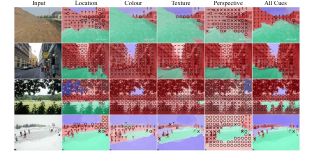

Fig.23 Recovering surface layout. The goal is to take an image and return a label indicating whether the pixel is part of a support surface (green pixels) vertical surface (red pixels) or the sky (blue pixels). Vertical surfaces were sub-classiﬁed into planar objects at diﬀerent orientations (left arrows, upward arrows and right arrows denote left-facing, fronto-parrallel and right- facing surfaces) and non-planar objects which can be porous (marked as ‘o’) or non-porous (marked as ‘x’. The ﬁnal classiﬁcation was based on (i) location cues (which include position in the image and position relative to the horizon), (ii) color cues, (iii) texture cues, and (iv) perspective cues, which were based on the statistics of line segments in the region. The ﬁgure shows example classiﬁcations for each of these cues alone and when combined. 

* **Support surface** (e.g., ground, floor) - Green pixels
* **Vertical surface** (e.g., buildings, walls) - Red pixels
* **Sky** - Blue pixels

The original algorithm also sub-classifies vertical surfaces into planar and non-planar categories, but this simplified version focuses on the three main classes.

## Algorithm Overview

The algorithm uses the following cues to classify pixels:

1.  **Location cues**: Position of the pixel in the image and its position relative to the horizon.
2.  **Color cues**: Color information of the pixel.
3.  **Texture cues**: Texture information of the region surrounding the pixel.
4.  **Perspective cues**: Statistics of line segments in the region (simplified to horizon relative positioning in this implementation).

The algorithm proceeds in the following steps:

1.  **Superpixel Segmentation**: The image is segmented into superpixels using a simple grid-based approach.
2.  **Feature Extraction**: Features are extracted for each superpixel, including location, color, texture, and perspective cues.
3.  **Classification**: A one-vs-all AdaBoost classifier is trained for each class, and the superpixels are classified based on the classifier outputs.
4.  **Label Map Creation**: The superpixel labels are used to create a per-pixel label map.

## Implementation

```python


Extracting features from training images...
Training one-against-all classifiers...
Training classifier for support...
Training classifier for vertical...
Training classifier for sky...


/home/radha/anaconda3/envs/cv37/lib/python3.7/site-packages/ipykernel_launcher.py:289: RuntimeWarning: overflow encountered in exp


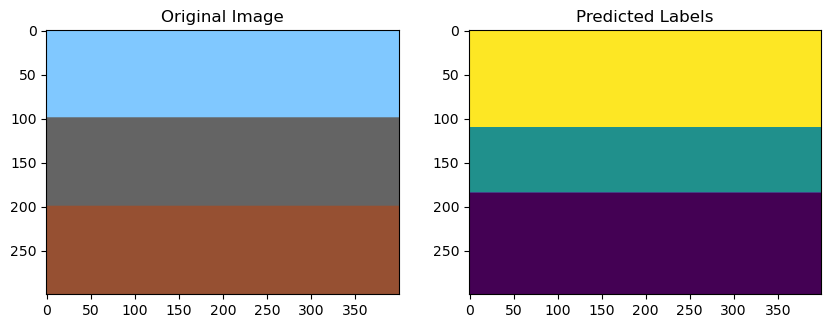

In [2]:
import numpy as np
import random
import math
from collections import defaultdict

class SurfaceLayoutRecovery:
    def __init__(self, n_estimators=50, random_seed=42):
        """
        Surface layout recovery (Hoiem et al., 2007)
        Implementation without external libraries
        
        Parameters:
        -----------
        n_estimators : int
            Number of weak classifiers in LogitBoost
        random_seed : int
            Random seed for reproducibility
        """
        self.n_estimators = n_estimators
        random.seed(random_seed)
        np.random.seed(random_seed)
        self.classifiers = {}
        
        # Define the three classes
        self.classes = {
            1: 'support',    # e.g., floor
            2: 'vertical',   # e.g., building
            3: 'sky'         # sky
        }
        
    def simple_superpixels(self, image, n_segments=100):
        """
        Simple superpixel segmentation using grid-based approach
        """
        h, w = image.shape[:2]
        
        # Determine grid size
        grid_h = int(np.sqrt(n_segments * h / w))
        grid_w = int(np.sqrt(n_segments * w / h))
        
        # Create initial grid segmentation
        segments = np.zeros((h, w), dtype=np.int32)
        segment_id = 0
        
        # Height and width of each cell
        cell_h = h // grid_h
        cell_w = w // grid_w
        
        for i in range(grid_h):
            for j in range(grid_w):
                # Calculate cell boundaries
                y_start = i * cell_h
                y_end = (i + 1) * cell_h if i < grid_h - 1 else h
                x_start = j * cell_w
                x_end = (j + 1) * cell_w if j < grid_w - 1 else w
                
                # Assign segment id
                segments[y_start:y_end, x_start:x_end] = segment_id
                segment_id += 1
        
        return segments
    
    def extract_texture_features(self, gray_image, mask):
        """
        Extract simple texture features from a grayscale image region
        """
        # Extract region
        y_indices, x_indices = np.where(mask)
        if len(y_indices) == 0:
            return np.zeros(5)
            
        region = gray_image[y_indices, x_indices]
        
        # Compute basic statistics
        mean = np.mean(region)
        std = np.std(region)
        min_val = np.min(region)
        max_val = np.max(region)
        range_val = max_val - min_val
        
        return np.array([mean, std, min_val, max_val, range_val])
    
    def extract_superpixel_features(self, image):
        """Extract features from superpixels without using external libraries"""
        # Convert to grayscale if color
        if len(image.shape) == 3:
            gray = np.mean(image, axis=2)
        else:
            gray = image.copy()
            
        # Generate superpixels
        segments = self.simple_superpixels(image, n_segments=100)
        
        # Extract features for each superpixel
        features = []
        
        for segment_id in np.unique(segments):
            mask = segments == segment_id
            
            # Get pixel coordinates for this superpixel
            y_coords, x_coords = np.where(mask)
            
            # Location features
            x_center = np.mean(x_coords) / image.shape[1]  # Normalized
            y_center = np.mean(y_coords) / image.shape[0]  # Normalized
            width = (np.max(x_coords) - np.min(x_coords)) / image.shape[1]
            height = (np.max(y_coords) - np.min(y_coords)) / image.shape[0]
            area = np.sum(mask) / (image.shape[0] * image.shape[1])
            
            location_features = [x_center, y_center, width, height, area]
            
            # Appearance features
            if len(image.shape) == 3:
                # Color features for each channel
                pixels = image[mask]
                color_mean = np.mean(pixels, axis=0)
                color_std = np.std(pixels, axis=0)
                appearance_features = list(color_mean) + list(color_std)
            else:
                # Grayscale features
                pixels = image[mask]
                appearance_features = [np.mean(pixels), np.std(pixels)]
            
            # Simple texture features
            texture_features = self.extract_texture_features(gray, mask)
            
            # Perspective features
            # Simple heuristic: percentage of superpixel above horizon line
            horizon_y = image.shape[0] // 2  # Assume horizon at middle of image
            above_horizon = np.sum(y_coords < horizon_y) / len(y_coords)
            perspective_features = [above_horizon]
            
            # Combine all features
            superpixel_features = location_features + appearance_features + list(texture_features) + perspective_features
            features.append(superpixel_features)
            
        return segments, np.array(features)
    
    def fit(self, images, labels):
        """
        Train surface layout recovery model
        
        Parameters:
        -----------
        images : list of numpy arrays
            List of training images
        labels : list of numpy arrays
            List of corresponding label maps (1=support, 2=vertical, 3=sky)
        """
        # Extract features from all training images
        all_features = []
        all_classes = []
        
        print("Extracting features from training images...")
        for image, label_map in zip(images, labels):
            segments, features = self.extract_superpixel_features(image)
            
            # Determine majority class for each superpixel
            for segment_id, feature_vector in zip(np.unique(segments), features):
                mask = segments == segment_id
                segment_labels = label_map[mask]
                
                # Count occurrences of each class
                class_counts = {}
                for pixel_label in segment_labels.flatten():
                    if pixel_label not in class_counts:
                        class_counts[pixel_label] = 0
                    class_counts[pixel_label] += 1
                
                # Find majority class
                majority_class = max(class_counts.items(), key=lambda x: x[1])[0]
                
                all_features.append(feature_vector)
                all_classes.append(majority_class)
        
        all_features = np.array(all_features)
        all_classes = np.array(all_classes)
        
        # Train one-against-all classifiers using AdaBoost (as an approx to LogitBoost)
        print("Training one-against-all classifiers...")
        for cls in self.classes.keys():
            print(f"Training classifier for {self.classes[cls]}...")
            binary_labels = (all_classes == cls).astype(int)
            
            # Use AdaBoost with decision stumps
            weak_classifiers, alphas = self.adaboost(all_features, binary_labels, self.n_estimators)
            
            self.classifiers[cls] = {
                'weak_classifiers': weak_classifiers,
                'alphas': alphas
            }
            
        return self
    
    def decision_stump(self, X, y, weights):
        """Simple decision stump for boosting"""
        n_samples, n_features = X.shape
        best_feature = 0
        best_threshold = 0
        best_error = float('inf')
        best_polarity = 1
        
        # Try each feature
        for feature_idx in range(n_features):
            feature_values = X[:, feature_idx]
            thresholds = np.unique(feature_values)
            
            # Try each threshold
            for threshold in thresholds:
                # Try both polarities
                for polarity in [-1, 1]:
                    # Predict
                    predictions = np.ones(n_samples)
                    if polarity == 1:
                        predictions[feature_values < threshold] = -1
                    else:
                        predictions[feature_values >= threshold] = -1
                    
                    # Calculate weighted error
                    error = np.sum(weights * (predictions != y))
                    
                    # Update best if better
                    if error < best_error:
                        best_error = error
                        best_feature = feature_idx
                        best_threshold = threshold
                        best_polarity = polarity
        
        return {
            'feature': best_feature,
            'threshold': best_threshold,
            'polarity': best_polarity,
            'error': best_error
        }
    
    def adaboost(self, X, y, n_estimators):
        """AdaBoost algorithm with decision stumps"""
        n_samples = X.shape[0]
        weights = np.ones(n_samples) / n_samples
        
        # Convert binary labels to -1/1
        y_boost = np.where(y == 1, 1, -1)
        
        weak_classifiers = []
        alphas = []
        
        for _ in range(n_estimators):
            # Train decision stump
            classifier = self.decision_stump(X, y_boost, weights)
            
            # Calculate alpha
            error = classifier['error']
            if error == 0:
                error = 1e-10  # Prevent division by zero
            alpha = 0.5 * np.log((1 - error) / error)
            
            # Update weights
            predictions = np.ones(n_samples)
            feature_values = X[:, classifier['feature']]
            if classifier['polarity'] == 1:
                predictions[feature_values < classifier['threshold']] = -1
            else:
                predictions[feature_values >= classifier['threshold']] = -1
                
            weights *= np.exp(-alpha * y_boost * predictions)
            weights /= np.sum(weights)  # Normalize
            
            weak_classifiers.append(classifier)
            alphas.append(alpha)
        
        return weak_classifiers, alphas
    
    def predict_adaboost(self, X, weak_classifiers, alphas):
        """Predict using trained AdaBoost ensemble"""
        n_samples = X.shape[0]
        scores = np.zeros(n_samples)
        
        for classifier, alpha in zip(weak_classifiers, alphas):
            predictions = np.ones(n_samples)
            feature_values = X[:, classifier['feature']]
            if classifier['polarity'] == 1:
                predictions[feature_values < classifier['threshold']] = -1
            else:
                predictions[feature_values >= classifier['threshold']] = -1
                
            scores += alpha * predictions
            
        # Convert scores to probabilities using sigmoid
        probabilities = 1 / (1 + np.exp(-2 * scores))
        return probabilities
    
    def predict(self, image):
        """
        Predict surface layout for image
        
        Parameters:
        -----------
        image : numpy array
            Input image
            
        Returns:
        --------
        label_map : numpy array
            Predicted surface layout map (1=support, 2=vertical, 3=sky)
        """
        # Extract superpixels and features
        segments, features = self.extract_superpixel_features(image)
        
        # Apply classifiers to get probabilities
        probabilities = np.zeros((len(features), len(self.classes)))
        
        for i, cls in enumerate(self.classes.keys()):
            classifier_data = self.classifiers[cls]
            
            # Get probability of positive class
            probs = self.predict_adaboost(
                features, 
                classifier_data['weak_classifiers'], 
                classifier_data['alphas']
            )
            probabilities[:, i] = probs
        
        # Normalize probabilities using softmax
        exp_probs = np.exp(probabilities)
        normalized_probs = exp_probs / np.sum(exp_probs, axis=1, keepdims=True)
        
        # Get most likely class for each superpixel
        predicted_classes = np.argmax(normalized_probs, axis=1) + 1  # +1 because classes are 1-indexed
        
        # Create label map
        label_map = np.zeros(image.shape[:2], dtype=int)
        
        for segment_id, cls in zip(np.unique(segments), predicted_classes):
            mask = segments == segment_id
            label_map[mask] = cls
        
        return label_map

def create_sample_image(width=400, height=300):
    """Create a sample image for testing"""
    image = np.zeros((height, width, 3), dtype=np.uint8)
    
    # Sky (top third)
    image[:height//3, :, :] = [128, 200, 255]  # Light blue
    
    # Building (middle third)
    image[height//3:2*height//3, :, :] = [100, 100, 100]  # Dark gray
    
    # Ground (bottom third)
    image[2*height//3:, :, :] = [150, 80, 50]  # Brown
    
    return image

# Create Sample Image
image = create_sample_image()

# Create Sample Label Map
label_map = np.zeros(image.shape[:2], dtype=int)
label_map[:image.shape[0]//3, :] = 3 #Sky
label_map[image.shape[0]//3:2*image.shape[0]//3, :] = 2 #Vertical
label_map[2*image.shape[0]//3:, :] = 1 #Support

# Train Model
model = SurfaceLayoutRecovery()
model.fit([image], [label_map])

# Predict
predicted_label_map = model.predict(image)

#Display results (Simplified)
import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(image)
plt.title("Original Image")
plt.subplot(1,2,2)
plt.imshow(predicted_label_map)
plt.title("Predicted Labels")
plt.show()

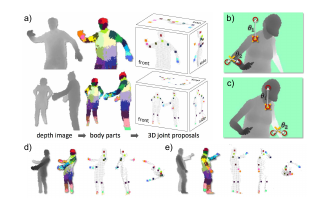

depth image x and assign a discrete label w to each pixel indicating which of 31 possible body parts is present. These depth labels are used to form proposals about the position of 3D joints. b) The classiﬁcation is based on decision trees. At each point in the tree, the data are divided according to the relative depth at two points (red circles) oﬀset relative to the current pixel (yellow crosses). In this example, this diﬀerence is large in both cases, whereas in c) this diﬀerence is small - hence these diﬀerences provide infor- mation about the pose. d,e) Two more examples of depth image, labeling and hypothesized pose.

## Human Part Identification (Shotton et al., 2011)

This notebook implements a simplified version of the human part identification system described in Shotton et al. (2011). The goal of this system is to take a depth image as input and assign a discrete label to each pixel, indicating which of 31 possible body parts is present. This intermediate representation is then used to estimate the 3D joint positions in the Microsoft Kinect gaming system.

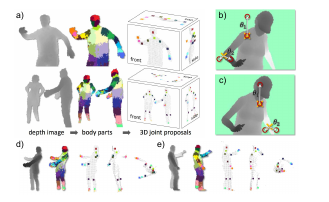

depth image x and assign a discrete label w to each pixel indicating which of 31 possible body parts is present. These depth labels are used to form proposals about the position of 3D joints. b) The classiﬁcation is based on decision trees. At each point in the tree, the data are divided according to the relative depth at two points (red circles) oﬀset relative to the current pixel (yellow crosses). In this example, this diﬀerence is large in both cases, whereas in c) this diﬀerence is small - hence these diﬀerences provide infor- mation about the pose. d,e) Two more examples of depth image, labeling and hypothesized pose. Adapted from Shotton et al. (2011) �2011 c IEEE .

## Algorithm Overview

The algorithm uses a forest of decision trees to classify pixels based on their relative depth values. Each decision tree makes decisions based on the difference in depth at two points offset from the current pixel. The final classification is an average of the predictions from all trees in the forest.

The key steps involved are:

1.  **Depth Feature Extraction**: Calculate the difference in depth between two offset points for each pixel.
2.  **Decision Tree Classification**: Use a forest of decision trees to classify each pixel based on the extracted depth features.
3.  **Label Aggregation**: Average the predictions from all trees to obtain the final label for each pixel.
4.  **3D Joint Position Estimation**: Use the label map to estimate the 3D joint positions (simplified in this implementation).

## Implementation


In [ ]:
import numpy as np
import random
import math
from collections import defaultdict

class HumanPartIdentifier:
    def __init__(self, n_trees=5, max_depth=10, n_parts=5, random_seed=42):
        """
        Human part identifier (Shotton et al., 2011)
        Implementation without external libraries
        
        Parameters:
        -----------
        n_trees : int
            Number of decision trees in the forest
        max_depth : int
            Maximum depth of each decision tree
        n_parts : int
            Number of body parts to identify (simplified)
        random_seed : int
            Random seed for reproducibility
        """
        self.n_trees = n_trees
        self.max_depth = max_depth
        self.n_parts = n_parts
        random.seed(random_seed)
        np.random.seed(random_seed)
        self.trees = []
        
    def generate_random_offsets(self, image_shape):
        """Generate random offsets for depth feature extraction"""
        h, w = image_shape
        offset_x1 = random.randint(-w // 4, w // 4)
        offset_y1 = random.randint(-h // 4, h // 4)
        offset_x2 = random.randint(-w // 4, w // 4)
        offset_y2 = random.randint(-h // 4, h // 4)
        return offset_x1, offset_y1, offset_x2, offset_y2
    
    def extract_depth_feature(self, depth_image, x, y, offset_x1, offset_y1, offset_x2, offset_y2):
        """Extract depth feature (difference between two offset points)"""
        h, w = depth_image.shape
        
        x1 = max(0, min(w - 1, x + offset_x1))
        y1 = max(0, min(h - 1, y + offset_y1))
        x2 = max(0, min(w - 1, x + offset_x2))
        y2 = max(0, min(h - 1, y + offset_y2))
        
        return depth_image[y1, x1] - depth_image[y2, x2]
    
    def create_decision_tree(self, depth_features, labels, depth, max_depth):
        """Create a decision tree recursively"""
        if depth == max_depth or len(np.unique(labels)) == 1:
            # Leaf node: return majority label
            counts = np.bincount(labels)
            return {'leaf': np.argmax(counts)}
        
        # Find best split
        best_feature = 0
        best_threshold = 0
        best_left = None
        best_right = None
        best_entropy = float('inf')
        
        n_features = depth_features.shape[1]
        for feature_idx in range(n_features):
            feature_values = depth_features[:, feature_idx]
            thresholds = np.unique(feature_values)
            
            for threshold in thresholds:
                left_mask = feature_values < threshold
                right_mask = feature_values >= threshold
                
                if np.sum(left_mask) == 0 or np.sum(right_mask) == 0:
                    continue
                
                left_labels = labels[left_mask]
                right_labels = labels[right_mask]
                
                # Calculate entropy
                left_probs = np.bincount(left_labels) / len(left_labels)
                right_probs = np.bincount(right_labels) / len(right_labels)
                
                left_entropy = 0 if len(left_probs) == 0 else -np.sum(left_probs * np.log2(left_probs + 1e-10))
                right_entropy = 0 if len(right_probs) == 0 else -np.sum(right_probs * np.log2(right_probs + 1e-10))
                
                entropy = (np.sum(left_mask) * left_entropy + np.sum(right_mask) * right_entropy) / len(labels)
                
                if entropy < best_entropy:
                    best_entropy = entropy
                    best_feature = feature_idx
                    best_threshold = threshold
                    best_left = left_mask
                    best_right = right_mask
        
        # Create child nodes
        left_tree = self.create_decision_tree(depth_features[best_left], labels[best_left], depth + 1, max_depth)
        right_tree = self.create_decision_tree(depth_features[best_right], labels[best_right], depth + 1, max_depth)
        
        return {
            'feature': best_feature,
            'threshold': best_threshold,
            'left': left_tree,
            'right': right_tree
        }
    
    def fit(self, depth_images, label_maps):
        """Train the human part identifier"""
        for _ in range(self.n_trees):
            # Extract depth features
            all_features = []
            all_labels = []
            
            for depth_image, label_map in zip(depth_images, label_maps):
                h, w = depth_image.shape
                features = []
                labels = []
                
                for y in range(h):
                    for x in range(w):
                        offset_x1, offset_y1, offset_x2, offset_y2 = self.generate_random_offsets(depth_image.shape)
                        feature = self.extract_depth_feature(depth_image, x, y, offset_x1, offset_y1, offset_x2, offset_y2)
                        features.append(feature)
                        labels.append(label_map[y, x])
                
                all_features.extend(features)
                all_labels.extend(labels)
            
            all_features = np.array(all_features).reshape(-1, 1) # Reshape to 2D
            all_labels = np.array(all_labels)
            
            # Create decision tree
            tree = self.create_decision_tree(all_features, all_labels, 0, self.max_depth)
            self.trees.append(tree)
        
        return self
    
    def predict_tree(self, depth_feature, tree):
        """Predict label using a single decision tree"""
        if 'leaf' in tree:
            return tree['leaf']
        
        if depth_feature[tree['feature']] < tree['threshold']:
            return self.predict_tree(depth_feature, tree['left'])
        else:
            return self.predict_tree(depth_feature, tree['right'])
    
    def predict(self, depth_image):
        """Predict labels for a depth image"""
        h, w = depth_image.shape
        label_map = np.zeros((h, w), dtype=int)
        
        for y in range(h):
            for x in range(w):
                tree_predictions = []
                for tree in self.trees:
                    offset_x1, offset_y1, offset_x2, offset_y2 = self.generate_random_offsets(depth_image.shape)
                    feature = self.extract_depth_feature(depth_image, x, y, offset_x1, offset_y1, offset_x2, offset_y2)
                    tree_predictions.append(self.predict_tree([feature], tree))
                
                # Average predictions (simplified: majority vote)
                counts = np.bincount(tree_predictions)
                label_map[y, x] = np.argmax(counts)
        
        return label_map
    
    def estimate_3d_joints(self, label_map, depth_image):
        """Estimate 3D joint positions (simplified)"""
        # In a real implementation, this would involve more sophisticated techniques
        # For simplicity, we just return the center of mass for each body part
        joint_positions = {}
        
        for part_id in range(self.n_parts):
            mask = label_map == part_id
            if np.any(mask):
                y_coords, x_coords = np.where(mask)
                center_x = np.mean(x_coords)
                center_y = np.mean(y_coords)
                depth = np.mean(depth_image[mask])
                joint_positions[part_id] = (center_x, center_y, depth)
            else:
                joint_positions[part_id] = None
                
        return joint_positions
    
# Create Sample Depth Image and Label Map
depth_image = np.random.rand(100, 100)
label_map = np.random.randint(0, 5, size=(100, 100))

# Train Model
model = HumanPartIdentifier()
model.fit([depth_image], [label_map])

# Predict
predicted_label_map = model.predict(depth_image)

# Estimate 3D Joints
joint_positions = model.estimate_3d_joints(predicted_label_map, depth_image)

# Display results (Simplified)
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.subplot(1, 3, 1)
plt.imshow(depth_image)
plt.title("Depth Image")

plt.subplot(1, 3, 2)
plt.imshow(label_map)
plt.title("Original Labels")

plt.subplot(1, 3, 3)
plt.imshow(predicted_label_map)
plt.title("Predicted Labels")
plt.show()

print("Estimated 3D Joint Positions:", joint_positions)    

# Human Part Identification (Shotton et al., 2011) - Details and Discussion

This section elaborates on the human part identification system described in Shotton et al. (2011), focusing on the depth feature extraction and the overall approach.

## Depth Feature Extraction

The key innovation in Shotton et al. (2011) is the use of relative depth differences as features. For each pixel, the algorithm calculates the difference in depth between two points offset from the current pixel. This is represented as:

$$
\text{feature} = \text{depth}(x + \text{offset}_x^1, y + \text{offset}_y^1) - \text{depth}(x + \text{offset}_x^2, y + \text{offset}_y^2)
$$

where $(x, y)$ are the coordinates of the current pixel, and $(\text{offset}_x^1, \text{offset}_y^1)$ and $(\text{offset}_x^2, \text{offset}_y^2)$ are the offsets for the two points.

The offsets are inversely scaled by the distance to the pixel itself, ensuring that the same relative positions on the body are considered even when the person moves closer or further away from the depth camera. This is crucial for robustness to distance variations.

## Decision Trees and Forest

The classification is based on a forest of decision trees. Each tree makes decisions based on the extracted depth features. The final probability $P(w|x)$ of a pixel belonging to body part $w$ given the depth image $x$ is an average (i.e., a mixture) of the predictions from all trees in the forest.

The use of a forest of trees helps to mitigate the biases introduced by the greedy method used to train individual trees.

## Training Data

The system was trained on a very large dataset of 900,000 synthesized depth images. These images were generated based on motion capture data, providing a rich and diverse training set.

## Performance

The system achieves a remarkable accuracy of 59% in assigning the correct body part label. While this may seem low, it provides a solid foundation for the subsequent 3D joint proposal stage.

## Discussion

This chapter has explored classification problems and highlighted the applicability of techniques developed for regression models to classification tasks. However, classification introduces a non-linear mapping between the input data $x$ and the parameters of the distribution $P(w|x)$, making it challenging to find closed-form maximum likelihood or exact Bayesian solutions.

Classification techniques are widely used in machine vision. However, these models often lack domain-specific information beyond the preprocessing of the data. This is both an advantage (broader applicability) and a disadvantage (limited ability to leverage prior knowledge).

In the remaining parts of this book, we will explore models that incorporate increasing amounts of domain-specific information to address these limitations.